# Group Project Proposal
#### Using KNN Classification to Predict Movie Genre

**Group Number:** 24

**Group Members:** Sienna Muller, Pascal Lo, Matthew Haryanto, Juan Pablo Villalobos

### Introduction: *Pascal*

*what to include:*

- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
- Clearly state the question you will try to answer with your project
- Identify and describe the dataset that will be used to answer the question

**Question:** Predicting the genre using a knn classification algorithm based on opening weekend profits, film budget, and profitability.

### Preliminary Exploratory Data Analysis: *Matthew*

*what to include:*

- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format
- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

In [2]:
# below are all of the libraries that must be imported for this project

library(tidyverse)
library(rvest) #not sure if we need this one
library(repr)
library(tidymodels)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────

In [116]:
# read dataset from the csv
options(repr.matrix.max.rows = 12)

url <- "https://raw.githubusercontent.com/reisanar/datasets/master/HollywoodMovies.csv"

hollywood_movies <- read_csv(url)
hollywood_movies

#rough code to check all the different genres
hollywood_movies|>
group_by(Genre)|>
summarize(DomesticGross = sum(DomesticGross))


Rows: 970 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): Movie, LeadStudio, Story, Genre
dbl (12): RottenTomatoes, AudienceScore, TheatersOpenWeek, OpeningWeekend, B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Movie,LeadStudio,RottenTomatoes,AudienceScore,Story,Genre,TheatersOpenWeek,OpeningWeekend,BOAvgOpenWeekend,DomesticGross,ForeignGross,WorldGross,Budget,Profitability,OpenProfit,Year
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Spider-Man 3,Sony,61,54,Metamorphosis,Action,4252,151.1,35540,336.53,554.34,890.87,258,345.30,58.57,2007
Shrek the Third,Paramount,42,57,Quest,Animation,4122,121.6,29507,322.72,476.24,798.96,160,499.35,76.00,2007
Transformers,Paramount,57,89,Monster Force,Action,4011,70.5,17577,319.25,390.46,709.71,150,473.14,47.00,2007
Pirates of the Caribbean: At World's End,Disney,45,74,Rescue,Action,4362,114.7,26302,309.42,654.00,963.42,300,321.14,38.23,2007
Harry Potter and the Order of the Phoenix,Warner Bros,78,82,Quest,Adventure,4285,77.1,17998,292.00,647.88,939.89,150,626.59,51.40,2007
I Am Legend,Warner Bros,69,69,Quest,Thriller,3606,77.2,21411,256.39,328.96,585.35,150,390.23,51.47,2007
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
The Butler,Weinstein,73,79,NA,NA,2933,24.64,8400,116.63,51.11,167.74,30,559.14,82.13,2013
The Canyons,IFC,22,NA,NA,NA,1,0.01,13351,0.06,0.14,0.19,NA,77.21,NA,2013


Genre,DomesticGross
<chr>,<dbl>
Action,16052.450
Adventure,2621.855
Animation,6675.610
Biography,884.470
Comedy,9320.085
Crime,782.040
⋮,⋮
Horror,2128.270
Musical,271.650


In [112]:
#split into training and testing data

hollywood_split <- initial_split(hollywood_movies, prop = 0.75, strata = Genre)
hollywood_training <- training(hollywood_split)
hollywood_testing <- testing(hollywood_split)

 Predicting the genre using a knn classification algorithm based on opening weekend profits, film budget, and profitability.tary

**I decided to use these groupigs because the shape in ggplot only allow for 6 variables, so what do you guys think.**
Action/Adventure/Fantasy <br> 
Romance/Drama <br>
Mystery/Crime <br>
Horror/Thriller <br>
Biography/Documentary <br>
Comedy/Musical/Animation

In [113]:
# clean/tidy data

hollywood_testing_tidy <- hollywood_testing |>
    select(Genre, OpeningWeekend, Budget, Profitability) |> # selecting the important columns
    filter(!is.na(Genre), !is.na(OpeningWeekend), !is.na(Budget), !is.na(Profitability)) |> # removes the NA
    mutate(Genre = as_factor(Genre)) |>
    mutate(Genre = case_when(
        Genre %in% c('Action', 'Adventure', 'Fantasy') ~ 'Action',
        Genre %in% c('Romance', 'Drama') ~ 'Romance',
        Genre %in% c('Mystery', 'Crime') ~ 'Mystery',
        Genre %in% c('Horror', 'Thriller') ~ 'Horror',
        Genre %in% c('Biography', 'Documentary') ~ 'Biography',
        Genre %in% c('Comedy', 'Musical', 'Animation') ~ 'Comedy')) |>
    arrange(Genre)
    # group_by(grp) |>
    # summarize(count = n())
   
hollywood_testing_tidy

Genre,OpeningWeekend,Budget,Profitability
<chr>,<dbl>,<dbl>,<dbl>
Action,70.5,150,473.14
Action,49.1,140,184.30
Action,58.0,130,222.34
Action,45.3,110,207.94
Action,25.7,180,206.80
Action,14.5,61,156.88
⋮,⋮,⋮,⋮
Romance,0.11,21,30.33
Romance,26.04,25,866.56


In [114]:
# summarize the data in at least one table

hollywood_testing_summary <- hollywood_testing_tidy |>
    group_by(Genre) |>
    summarize(OpeningWeekendAvg = mean(OpeningWeekend), BudgetAvg = mean(Budget), ProfitabilityAvg = mean(Profitability), count = n())
hollywood_testing_summary

Genre,OpeningWeekendAvg,BudgetAvg,ProfitabilityAvg,count
<chr>,<dbl>,<dbl>,<dbl>,<int>
Action,40.187059,108.96078,248.2310,51
Biography,13.252000,28.30000,870.0640,5
Comedy,22.524528,61.32075,315.6179,53
Horror,24.997273,39.18182,875.3123,22
Mystery,6.586667,16.66667,988.4267,3
Romance,13.711667,29.68889,446.0928,36


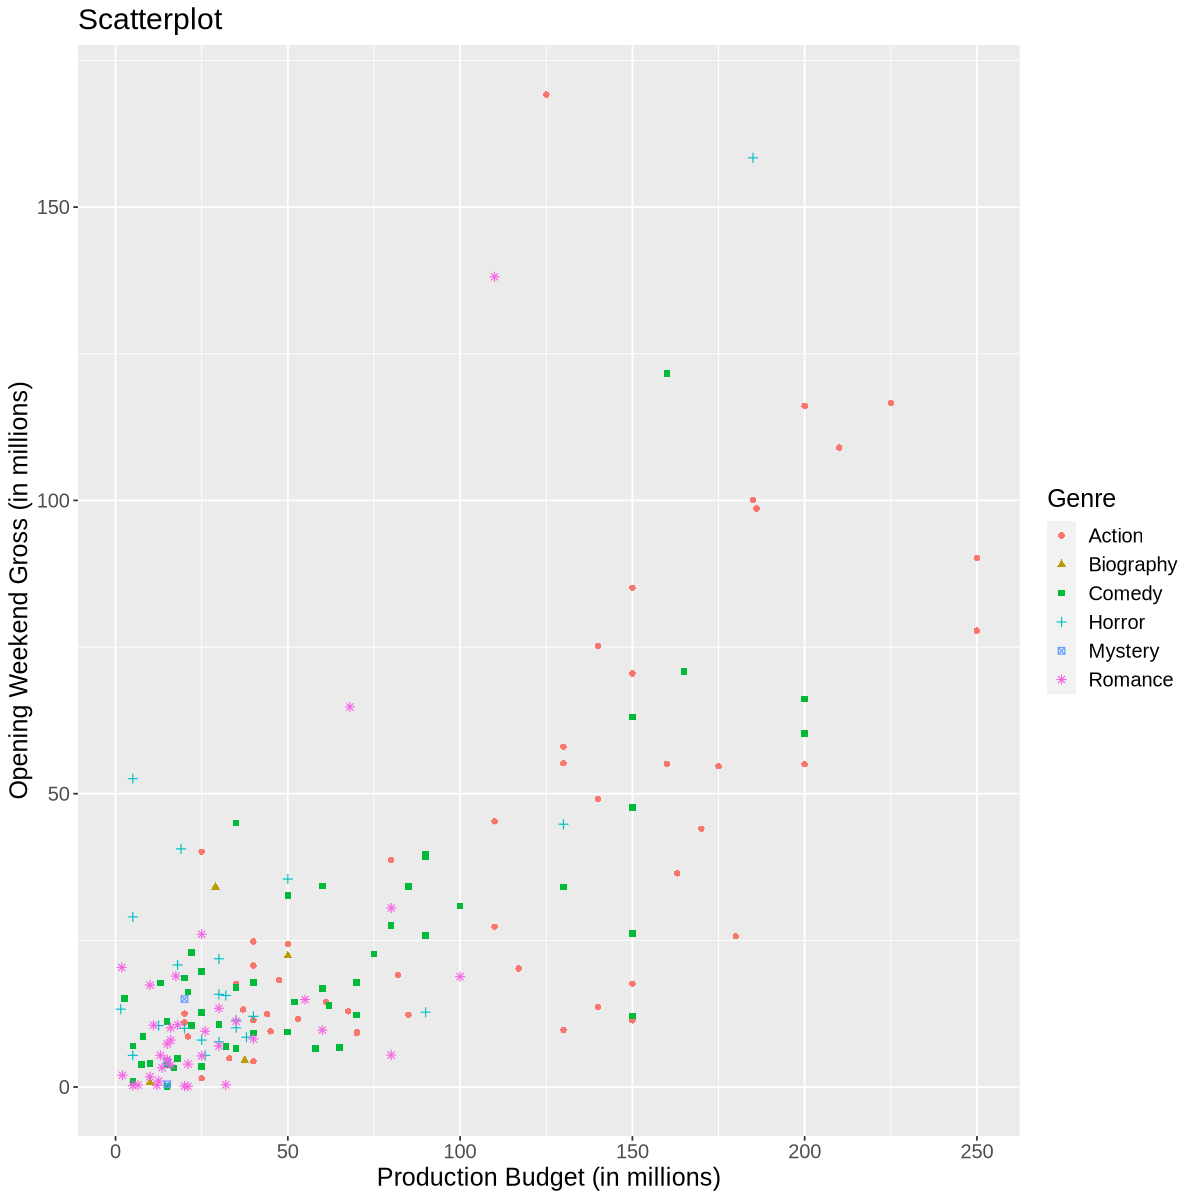

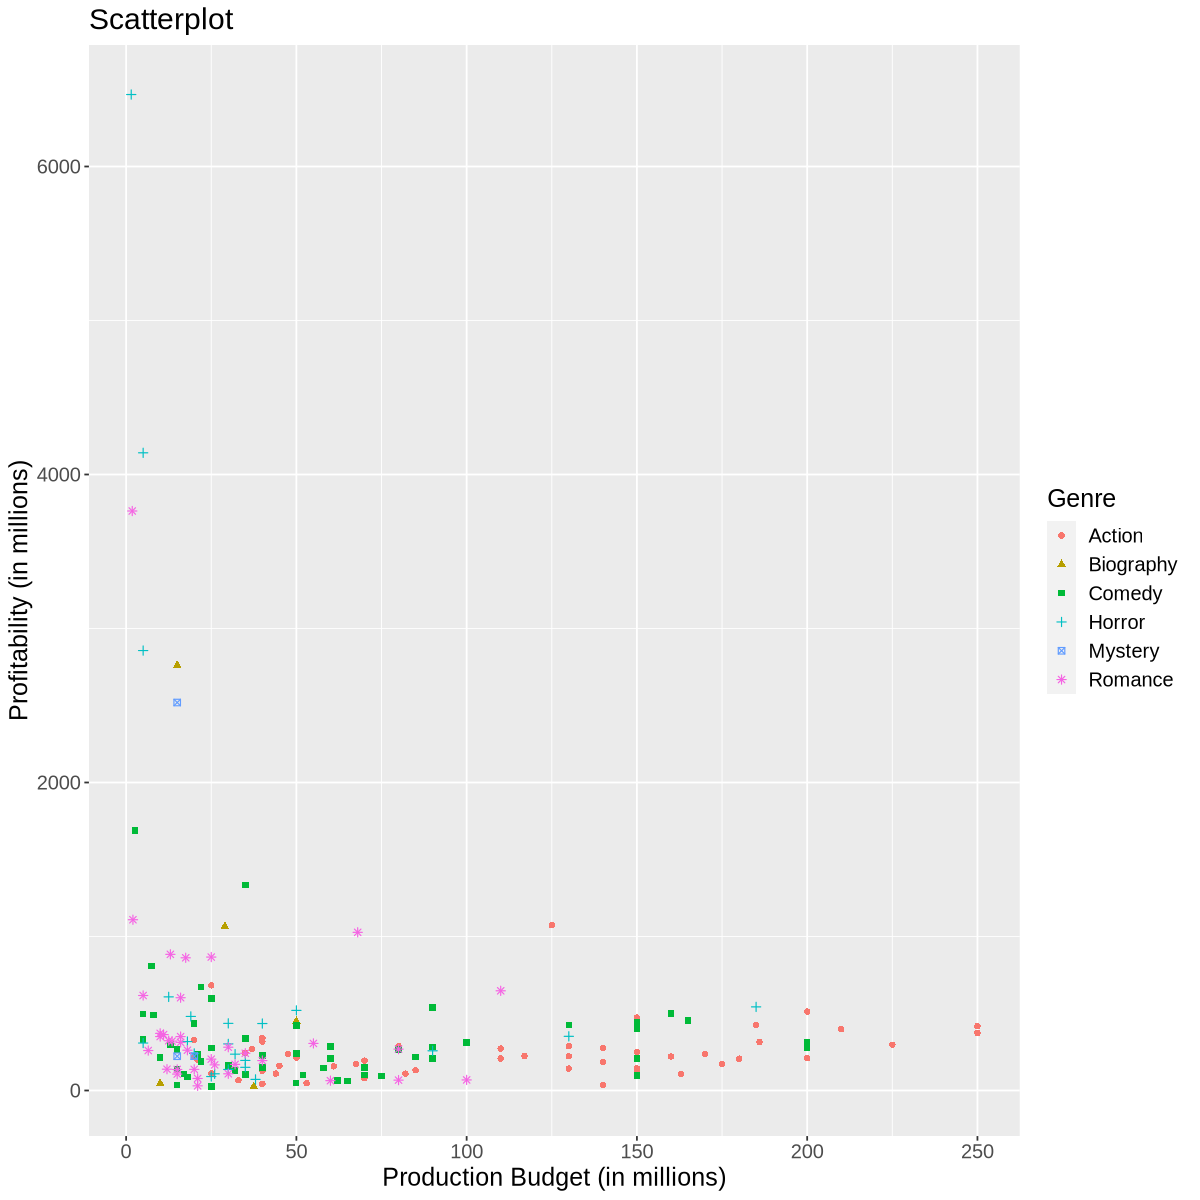

In [115]:
# visualize with one plot relevant to planned analysis
options(repr.plot.width = 10, repr.plot.height = 10)

hollywood_plot_opening <- hollywood_testing_tidy |>
    ggplot(aes(x = Budget, y = OpeningWeekend, colour = Genre, shape = Genre)) +
    geom_point() +
    labs(x = "Production Budget (in millions)", y = "Opening Weekend Gross (in millions)",) +
    ggtitle("Scatterplot") +
    theme(text = element_text(size = 15))

hollywood_plot_profit <- hollywood_testing_tidy |>
    ggplot(aes(x = Budget, y = Profitability, colour = Genre, shape = Genre)) +
    geom_point() +
    labs(x = "Production Budget (in millions)", y = "Profitability (in millions)",) +
    ggtitle("Scatterplot") +
    theme(text = element_text(size = 15))


hollywood_plot_opening
hollywood_plot_profit

### Methods: *Pablo*

*what to include:*

- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

grouping genres by:
- action/adventure
- Romance/Drama
- Mystery/crime
- Horror/thriller
- biography/documentary 

### Expected Outcomes and Significance:

Based on the dataset, we predict that the action/adventure films will have a higher budget, but also higher profitability and opening weekend success. In addition, that biography/documentary films will have a lower profitability and opening weekend success, with a medium budget. The other genre groups are predicted to be seen in the middle range, impacting how films are grouped into their genre.

The findings could be used by the producing studios to plan movies (based on genre) for the intended budget, high profitability, and to ensure success at the opening weekend. Using the knn classification algorithm, the intended budget and hoped profitability/opening weekend success can be used to predict, and ultimately plan the genre of the next film. 

This proposed project could lead to many future questions (through the inclusion of other aspects of the dataset), including:

- Can the model created be applied to films outside Hollywood (in other regions of the globe), tv shows, and other forms of media?
- If the films are sequels, and this was considered in the model, how would this impact the predictions made?
- Are there any clear biases in the model created? 
- How does the studio producing the film relate to the predicted genre?
- Can the genre be selected through both minimizing the budget, and maximizing profitability?

Ultimately, we feel that this model can provide as a base for film planning, but it will also lead to further complications/considerations that should be added to improve its classification and accuracy when making predictions. It will be important for us to consider whether the selected columns and values intended to predict genre are sufficient.

